In [1]:
import sys
sys.path.append('../')
import joblib

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import AdaMaskBINNCovasim
from Modules.Utils.ModelWrapper import ModelWrapper

from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

import Modules.Utils.PDESolver as PDESolver
import Modules.Loaders.DataFormatter as DF
from utils import get_case_name, plot_loss_convergence

c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

Device set to cpu


In [3]:
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'
# path = '../Data/covasim_data/xin_data/'

# data parameters
population = int(500e3)
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = 0
multiple = True
parallelb = True
n_runs = 64
chi_type = 'piecewise'

# model parameters
maskb = False
masking_learned = False

case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)

In [4]:
if not masking==0:
    if masking==1:
        case_name = case_name + '_maskingdem'
    elif masking==2:
        case_name = case_name + '_maskinguni'
    elif masking==3:
        case_name = case_name + '_maskingnorm'

if multiple:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)
else:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name, plot=False)

In [5]:
# split into train/val and convert to torch
# multiple==True and parallelb==False means that data is a list and not normalized
if multiple and not parallelb:
    data = np.mean(params['data'], axis=0)
    data = (data / params['population'])
    avg_masking = np.mean(params['avg_masking'], axis=0)
    avg_masking = (avg_masking / params['population'])
# multiple==True and parallelb==True means that the data is a 2d array and normalized
elif multiple and parallelb:
    data = params['data'] # parallel simulations store normalized data
    avg_masking = params['avg_masking']
# otherwise, the data is from a single simulation and is not normalized
else:
    data = params['data']
    data = (data / params['population']).to_numpy()
    avg_masking = params['avg_masking']
    avg_masking = (avg_masking / params['population'])
    
params.pop('data')

N = len(data)
t_max = N - 1
t = np.arange(N)[:,None]

tracing_array = params['tracing_array']

In [6]:
if masking > 0 and masking_learned == True:
    all_data = np.concatenate([data, avg_masking[:,None]], axis=1)
    sparse_coef_path = path + 'mt_eq_coef/'
    if multiple:
        ml_dict = joblib.load(sparse_coef_path + case_name + '_' + str(n_runs) + '_sparse_coef_29comps')
    else:
        ml_dict = joblib.load(sparse_coef_path + case_name + '_sparse_coef_29comps')
    params['mask_coef'] = np.append(np.array(ml_dict['Lasso'].intercept_), ml_dict['Lasso'].coef_)
else:
    all_data = data

In [7]:
model_path = '../models/covasim'
if maskb:
    model_path += '/mask'
    if masking_learned:
        model_path += '/learned_masking'
    else:
        model_path += '/observed_masking'
else:
    model_path += '/no_mask'

In [8]:
#--------------------no masking----------------------#
# model_folder = '/2023-07-20_17-53-03' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 800e3 epochs, lr=1e-5
model_folder = '/2023-07-21_18-42-24' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 1e6 epochs, lr=1e-6
# model_folder = '/2023-07-22_10-20-01' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 1e6 epochs, lr=5e-6
# model_folder = '/2023-07-23_00-48-24' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 1e6 epochs, lr=9e-6

#------------------normal masking--------------------#
# model_folder = '/2023-07-20_18-13-01' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-21_18-41-30' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-21_21-48-16' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-22_10-16-47' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-22_12-40-47' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-23_00-27-07' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5

#---------------demographic masking------------------#
# model_folder = '/2023-07-20_22-20-10' # masking-dem, observed M, 500e3, dynamic piecewise, 64 avg., 600e3, lr=5e-5

mydir = model_path + model_folder

In [9]:
# mydir = '../models/covasim/mask/2023-07-13_23-46-11' # norm masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 200,000 epochs, lr=1e-4
# mydir = '../models/covasim/mask/2023-07-16_16-48-08' # norm masking, 500e3 pop, dynamic piecewise, keepd, 2048 avg., 800,000 epochs, lr=5e-5
# mydir = '../models/covasim/no_mask/2023-07-18_18-53-36' # no masking, 500e3 pop, dynamic piecewise, keepd, 64 avg., 500,000 epochs, lr=5e-5
# mydir = '../models/covasim/mask/2023-07-19_22-22-04' # norm masking, 500e3 pop, dynamic piecewise, keepd, 64 avg., 600,000 epochs, lr=5e-5
# mydir = '../models/covasim/mask/2023-07-19_22-21-24' # dem masking, 500e3 pop, dynamic piecewise, keepd, 64 avg., 600,000 epochs, lr=5e-5
# mydir = '../models/covasim/no_mask/2023-07-19_22-21-50' # no masking, 500e3 pop, dynamic piecewise, keepd, 64 avg., 700,000 epochs, lr=1e-5

In [10]:
# instantiate BINN model
yita_lb = 0.0
yita_ub = 1.0
beta_lb = 0.0
beta_ub = 0.5
tau_lb = 0.05
tau_ub = 0.40
eta_deep = True
beta_deep = True
tau_deep = False

binn = AdaMaskBINNCovasim(params, 
                t_max_real=t_max, 
                tracing_array=tracing_array, 
                yita_lb=None, 
                yita_ub=None,
                beta_lb=None,
                beta_ub=None,
                tau_lb=tau_lb,
                tau_ub=tau_ub, 
                chi_type=chi_type,
                eta_deep=eta_deep,
                beta_deep=beta_deep,
                tau_deep=tau_deep,
                maskb=maskb,
                masking_learned=masking_learned).to(device)

parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [11]:
# load model weights. if retrain==True then load the retrained model
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)

# grab initial condition
u0 = data[0, :].copy()

In [12]:
if not masking_learned and maskb:
    # B-spline
    best_val_score = -1
    max_degree = 12
    for i in range(2, t.shape[0] // 2):
        for j in range(1, max_degree + 1):
            interp = make_pipeline(SplineTransformer(i, degree=j), Ridge(alpha=1e-6))
            interp.fit(t, avg_masking)
            if interp.score(t, avg_masking) > best_val_score:
                best_interp = interp
                best_val_score = best_interp.score(t, avg_masking)
            
            
    plt.plot(t, avg_masking)
    plt.plot(t, best_interp.predict(t))
    t_interp = np.linspace(0, 183, num=1000).reshape(-1, 1)
    avg_masking_interp = best_interp.predict(t_interp)

In [13]:
# learned surface fitter
def surface_fitter(t):
    res = binn.surface_fitter(to_torch(t))
    return res

# learned contact_rate function
def contact_rate(u):
    res = binn.eta_func(to_torch(u))
    return to_numpy(res)

# learned effective tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)

# learned diagnosis of quarantined rate function
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

In [14]:
# simulate PDE. First grab the parameter values from the loaded BINN model.
params['yita_lb'] = model.model.yita_lb
params['yita_ub'] = model.model.yita_ub
params['beta_lb'] = model.model.beta_lb
params['beta_ub'] = model.model.beta_ub
params['tau_lb'] = model.model.tau_lb
params['tau_ub'] = model.model.tau_ub

In [15]:
# if D is to be included in the model, otherwise use the other solver.
if maskb:
    if not masking_learned:
        params['avg_masking'] = avg_masking_interp
    else:
        params['avg_masking'] = surface_fitter(t)[:,9].detach().numpy()

In [16]:
if keep_d:
    if masking > 0:
        RHS = PDESolver.STEAYDQRF_RHS_dynamic_maskarr
        u_sim_NN = PDESolver.STEAYDQRF_sim(RHS, u0, t, contact_rate, beta, tau, params, chi_type, regression=False)
    else:
        RHS = PDESolver.STEAYDQRF_RHS_dynamic
        u_sim_NN = PDESolver.STEAYDQRF_sim(RHS, u0, t, contact_rate, beta, tau, params, chi_type, regression=False)
    u_sim_NN *= population

c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:465: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([ds, dt, de, da, dy, dd, dq, dr, df])


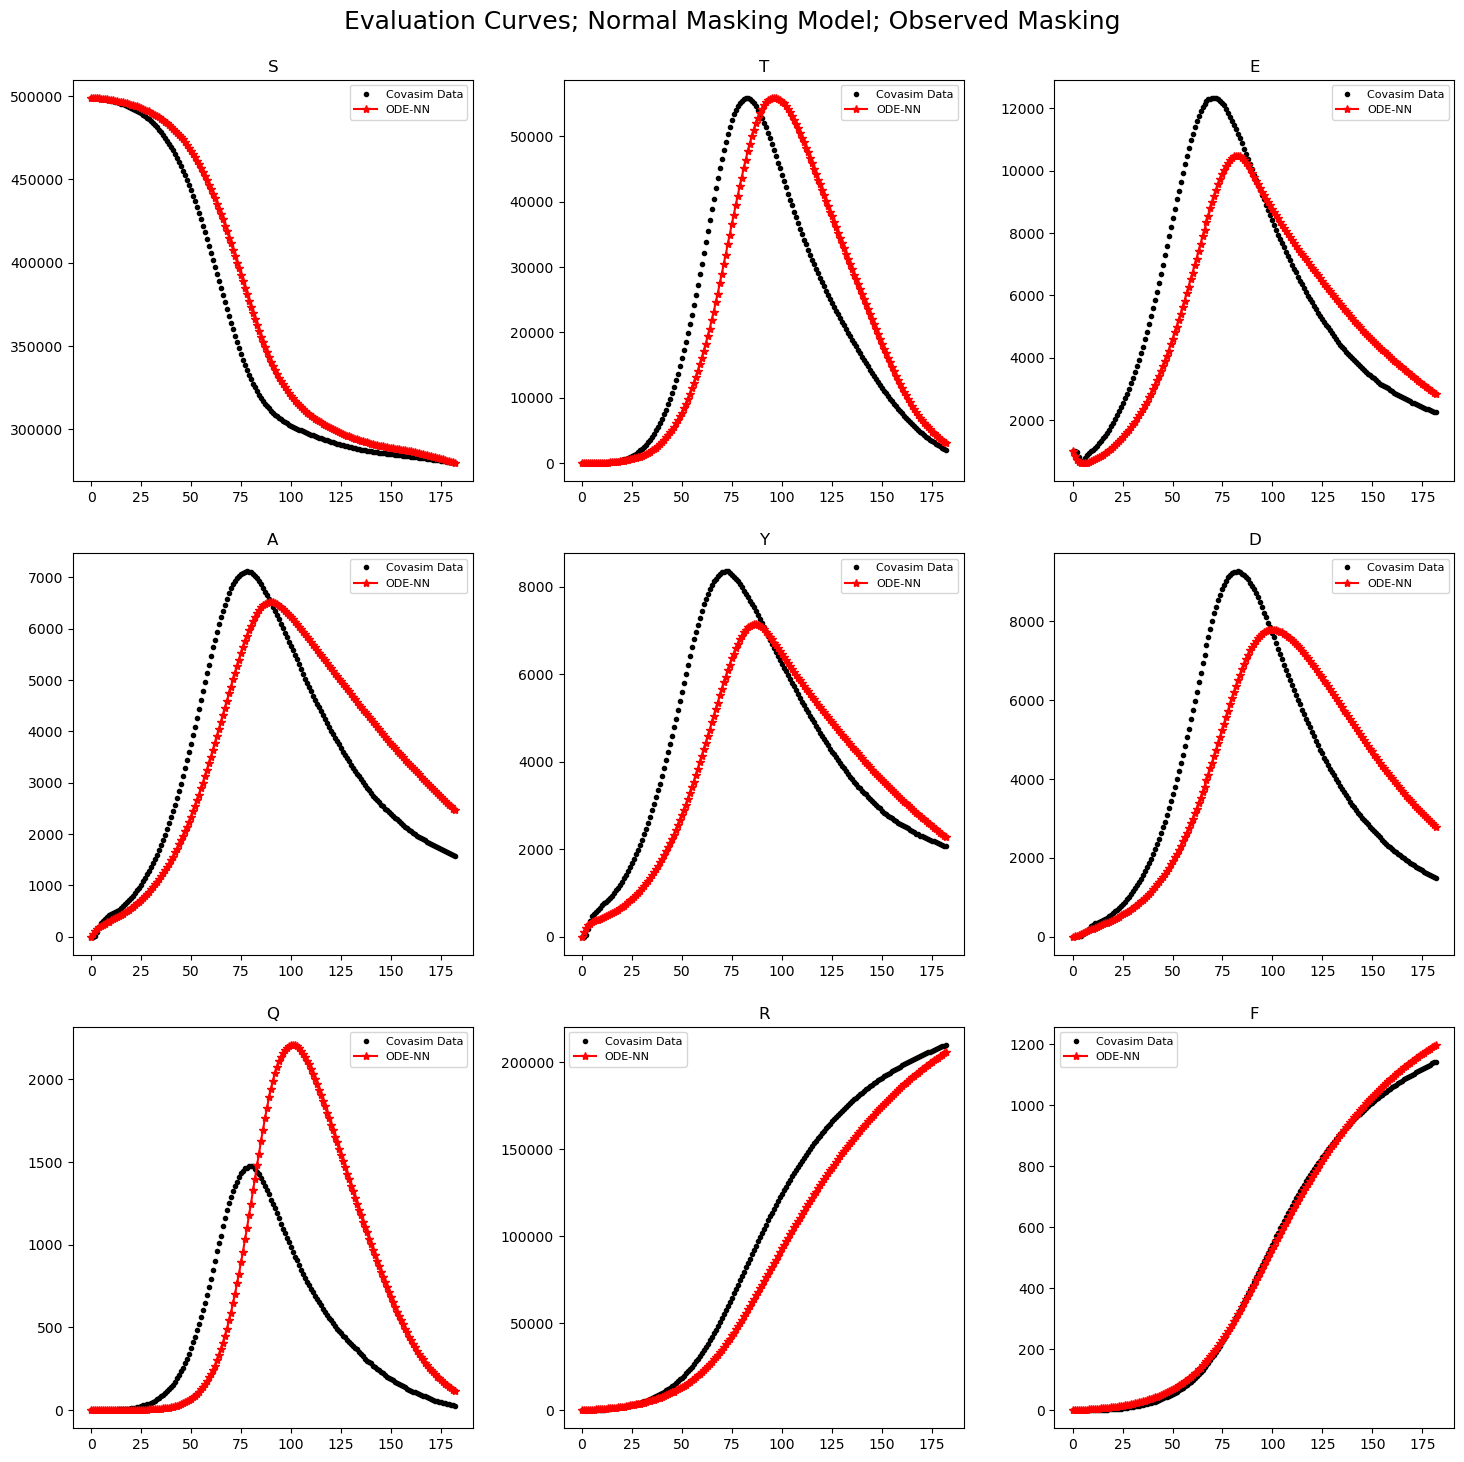

In [17]:
# rescale data values to represent number of people in state X rather than ratios
scaled_data = data * population

plot=True
if plot:
    n = scaled_data.shape[1]
    col_names = list('STEAYDQRF') if keep_d else list('STEAYQRF')
    # plot compartments
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle('Evaluation Curves; Normal Masking Model; Observed Masking', size=18)
    for i in range(1, n + 1):
        ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)
        ax.plot(t, scaled_data[:, i - 1], '.k', label='Covasim Data')
        ax.plot(t, u_sim_NN[:, i - 1], '-*r', label='ODE-NN')
        ax.set_title(col_names[i - 1])
        ax.legend(fontsize=8)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        plt.savefig(os.path.join(model.save_folder, case_name + '.png'), dpi=400)
        # plt.show()

### Evaluation with LASSO estimates of learned parameters

In [18]:
# load the LASSO dictionaries for each parameter with the specifc number of nonzero component coefficients
eta_ld = joblib.load(model.save_folder + '/eta_eq_coef/' + case_name + '_' + str(n_runs) + '_sparse_coef_8comps')
beta_ld = joblib.load(model.save_folder + '/beta_eq_coef/' + case_name + '_' + str(n_runs) + '_sparse_coef_8comps')
tau_ld = joblib.load(model.save_folder + '/tau_eq_coef/' + case_name + '_' + str(n_runs) + '_sparse_coef_6comps')

In [19]:
poly = PolynomialFeatures(2)
if maskb:
    all_data = np.concatenate((data, avg_masking[:,None]), axis=1)
else:
    all_data = data
X = poly.fit_transform(all_data)

eta_coef = np.append(eta_ld['Lasso'].intercept_, eta_ld['Lasso'].coef_)
beta_coef = np.append(beta_ld['Lasso'].intercept_, beta_ld['Lasso'].coef_)
tau_coef = np.append(tau_ld['Lasso'].intercept_, tau_ld['Lasso'].coef_)

In [20]:
eta_reg_coef = eta_coef[eta_coef.nonzero()]
beta_reg_coef = beta_coef[beta_coef.nonzero()]
#tau_reg_coef = np.where(np.abs(tau_coef) < float(1e-6), 0, tau_coef)
#tau_reg_coef = tau_reg_coef[tau_reg_coef.nonzero()]
tau_reg_coef = tau_coef[tau_coef.nonzero()]

In [24]:
tau_ld

{'Lasso': LassoCV(alphas=array([1.e-08]), cv=5),
 'Equation': 'f = 0.00015*S + 0.00007*E + -0.00063*R + -0.00058*S^2 + 0.00252*S E + -0.00019*R^2 + 0.06402',
 'MSE': 1.6560911026999826e-11}

In [21]:
# learned contact_rate function
def eta_lasso(u):
    s, tq, e, a, y, d, q, r, f = u[:,0][:,None], u[:, 1][:,None], u[:, 2][:,None], u[:, 3][:,None], u[:, 4][:,None],\
                                  u[:, 5][:,None], u[:, 6][:,None], u[:,7][:,None],  u[:, 8][:,None]
    if maskb:  m = u[:,9][:,None]
    features = np.array([np.ones_like(s), s, e, r, s**2, s*r, tq**2, tq*r, r**2])[:,None]
    res = np.matmul(features.T, eta_reg_coef)[0]
    return res

# learned effective tracing rate function
def beta_lasso(u):
    s, tq, e, a, y, d, q, r, f = u[:,0][:,None], u[:, 1][:,None], u[:, 2][:,None], u[:, 3][:,None], u[:, 4][:,None],\
                                  u[:, 5][:,None], u[:, 6][:,None], u[:,7][:,None],  u[:, 8][:,None]
    features = np.array([np.ones_like(s), s, tq, r, s**2, s*tq, tq**2, tq*r, r**2])[:,None]
    res = np.matmul(features.T, beta_reg_coef)[0]
    return res

# learned diagnosis of quarantined rate function
def tau_lasso(u):
    s, tq, e, a, y, d, q, r, f = u[:,0][:,None], u[:, 1][:,None], u[:, 2][:,None], u[:, 3][:,None], u[:, 4][:,None],\
                                  u[:, 5][:,None], u[:, 6][:,None], u[:,7][:,None],  u[:, 8][:,None]
    features = np.array([np.ones_like(s), s, e, r, s**2, s*e, r**2])[:,None]
    res = np.matmul(features.T, tau_reg_coef)[0]
    return res

In [22]:
# if D is to be included in the model, otherwise use the other solver.
if masking > 0:
    params['avg_masking'] = avg_masking_interp
if keep_d:
    if masking > 0:
        RHS = PDESolver.STEAYDQRF_RHS_dynamic_maskarr
        reg_sim_NN = PDESolver.STEAYDQRF_sim(RHS, u0, t, eta_lasso, beta_lasso, tau_lasso, params, chi_type, regression=True)
    else:
        RHS = PDESolver.STEAYDQRF_RHS_dynamic
        reg_sim_NN = PDESolver.STEAYDQRF_sim(RHS, u0, t, eta_lasso, beta_lasso, tau_lasso, params, chi_type, regression=True)
    reg_sim_NN *= population

c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:465: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([ds, dt, de, da, dy, dd, dq, dr, df])


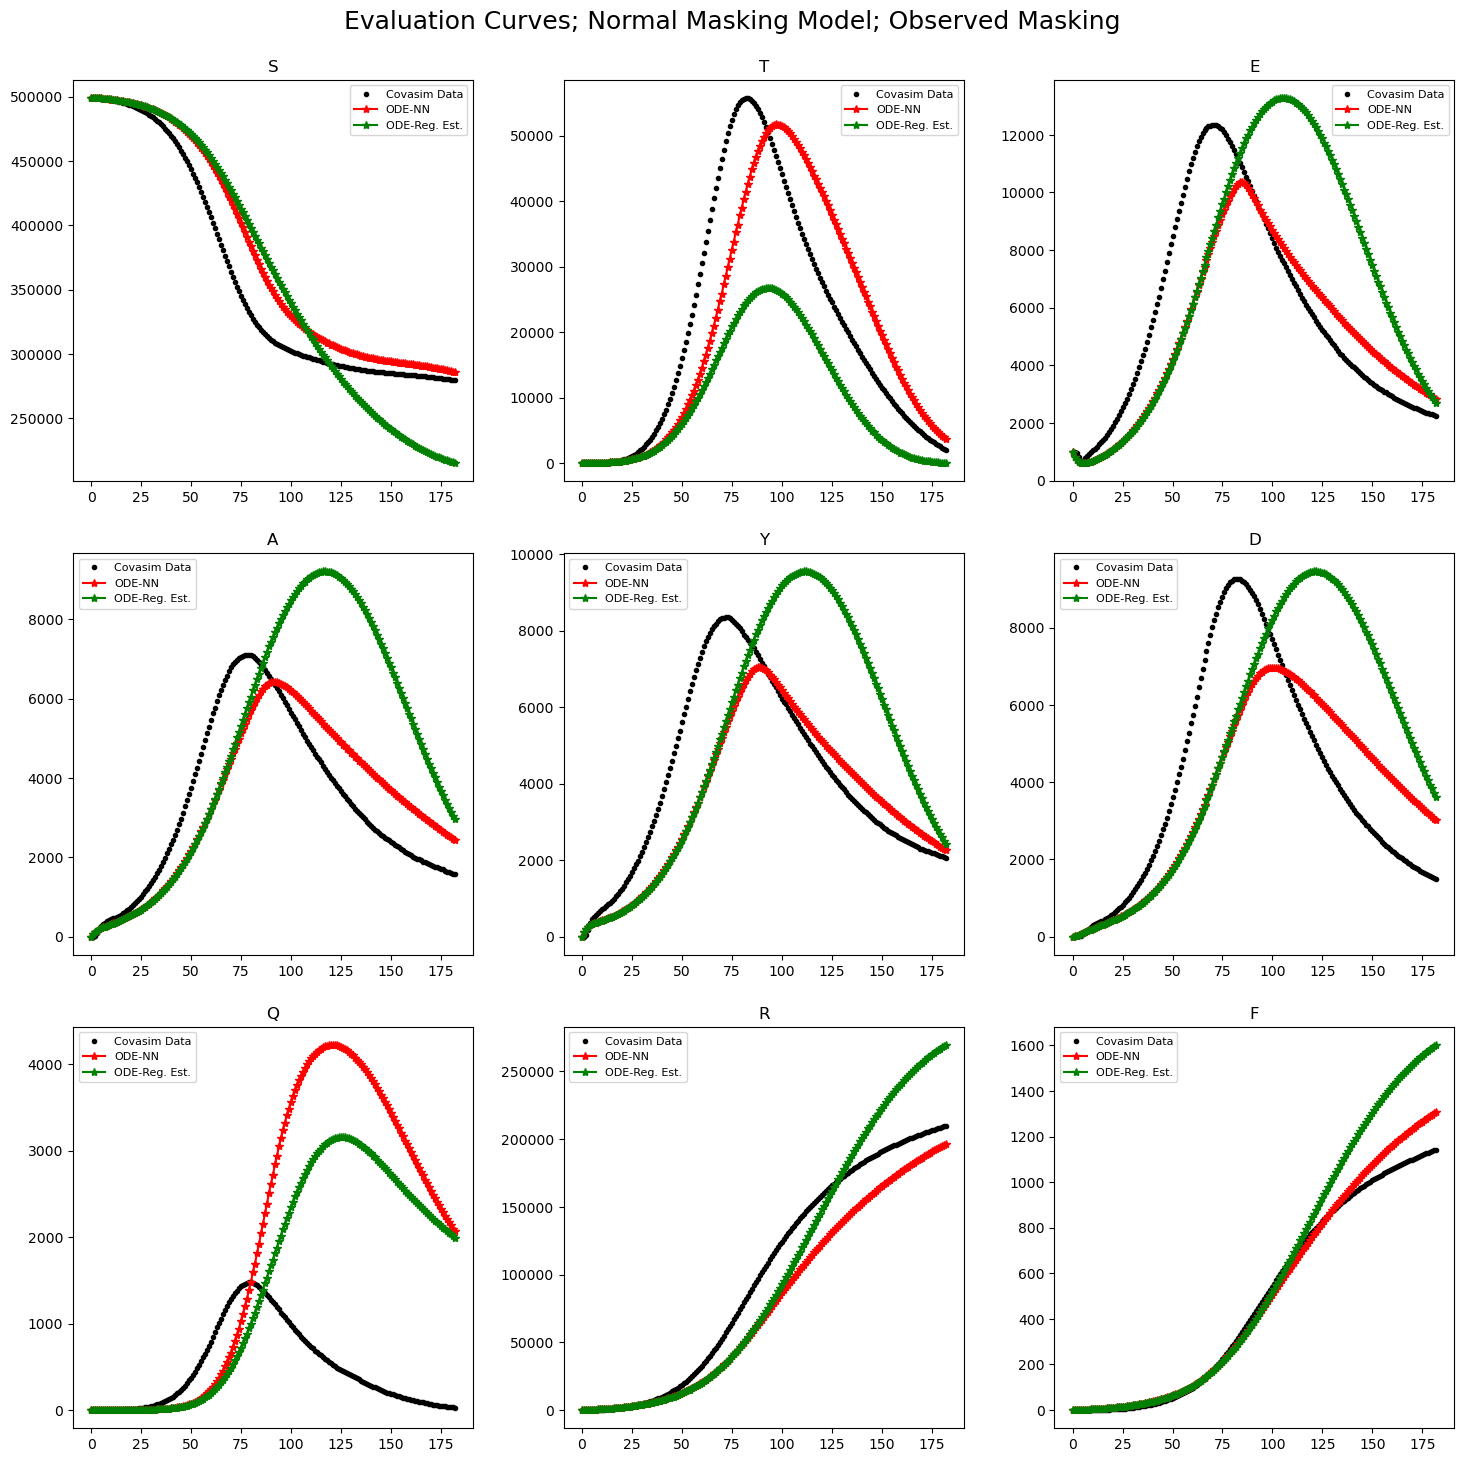

In [23]:
# rescale data values to represent number of people in state X rather than ratios
scaled_data = data * population

plot=True
if plot:
    n = scaled_data.shape[1]
    col_names = list('STEAYDQRF') if keep_d else list('STEAYQRF')
    # plot compartments
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle('Evaluation Curves; Normal Masking Model; Observed Masking', size=18)
    for i in range(1, n + 1):
        ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)
        ax.plot(t, scaled_data[:, i - 1], '.k', label='Covasim Data')
        ax.plot(t, u_sim_NN[:, i - 1], '-*r', label='ODE-NN')
        ax.plot(t, reg_sim_NN[:, i - 1], '-*g', label='ODE-Reg. Est.')
        ax.set_title(col_names[i - 1])
        ax.legend(fontsize=8)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        plt.savefig(os.path.join(model.save_folder, case_name + '_regression.png'), dpi=400)
        # plt.show()